In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
# Read dataset #
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

In [3]:
# HYPER PARAMETERS #
number = 5
computer_words = ['the','for','would','not','will','is','I','because','of','in','we','you','your','love','hate','hi','bye','to','can','should','he','she','him','her','could','like','a','an','over','under','cars','.',',','shall']
computer_words = set(computer_words)

In [4]:
len(computer_words)

34

In [5]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [6]:
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [7]:
test_essays.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [8]:
# Generate computer words frequency dataset # 
fcolumns = list(computer_words)
fcolumns.append('generated')
fcolumns.append('id')
frequency_dt = pd.DataFrame([],columns=fcolumns)
for index,row in train_essays.iterrows():
    words = nltk.word_tokenize(row['text'])
    fd= nltk.FreqDist(words)
    tmp = {}
    for i in computer_words:tmp[i] = fd[i]
    tmp['generated'] = row['generated']
    tmp['id'] = row['id']
    frequency_dt.loc[len(frequency_dt)] = tmp
frequency_dt.head()

,would,your,to,because,he,is,should,under,",",can,...,a,will,not,.,hate,in,for,you,generated,id
0,3,0,21,5,0,4,1,0,40,2,...,15,0,0,23,0,8,7,2,0,0059830c
1,6,1,10,0,0,5,1,0,24,3,...,18,0,3,26,0,16,2,1,0,005db917
2,3,3,28,0,0,19,0,0,29,1,...,19,2,7,48,0,14,6,3,0,008f63e3
3,3,8,20,0,2,8,0,0,38,3,...,18,0,4,37,0,14,2,12,0,00940276
4,6,5,31,0,0,20,0,0,35,1,...,25,1,8,47,0,21,1,3,0,00c39458


In [9]:
# Split data to train and test #
freq_train, freq_test = train_test_split(frequency_dt, test_size=0.2)
freq_train.head()

,would,your,to,because,he,is,should,under,",",can,...,a,will,not,.,hate,in,for,you,generated,id
907,6,1,13,7,2,7,6,0,1,4,...,9,0,5,23,0,4,7,1,0,a2b8855e
1312,0,0,27,2,0,16,0,0,22,1,...,6,1,4,35,0,20,4,1,0,f3914f7c
1229,0,0,27,2,0,11,2,0,23,2,...,10,9,3,16,0,12,12,4,0,e579884d
169,8,0,9,0,0,5,2,0,11,1,...,7,1,6,17,0,1,8,0,0,212ae7f0
1323,0,3,10,0,1,5,0,0,39,3,...,12,0,3,27,0,7,6,2,0,f4ba4463


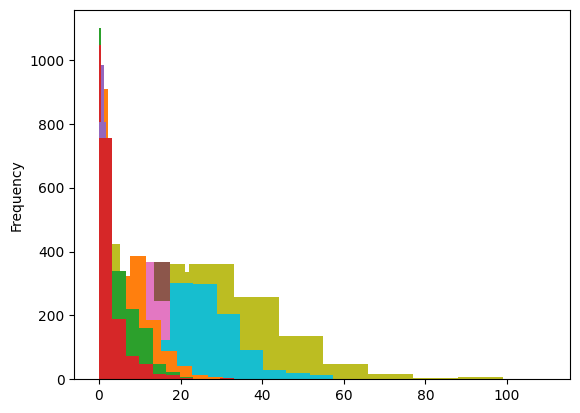

In [10]:
# plot to check words distribution #
for i in computer_words:
    freq_train[i].plot(kind='hist')

In [11]:
# calculate word occurrence in essays and apply softening/smoothing where required #
counter_w = {}
counter_wC = {}
counter_C = 0
for index,row in freq_train.iterrows():
    if row['generated']:counter_C+=1
    for i in computer_words:
        if row[i]>=number:
            if i in counter_w.keys():counter_w[i]+=1
            else:counter_w[i] = 1
            if row['generated']:
                if i in counter_wC.keys():counter_wC[i]+=1
                else:counter_wC[i] = 1
            else:counter_wC[i] = 0

In [12]:
# calculate word probabilities and store in dictionary #
total_docs = len(frequency_dt)
prob_C = counter_C / total_docs
prob_w= {}
prob_wC = {}

for key,val in counter_w.items():
    if val <=0:
        total_docs+=1
        counter_w[key]=val+1
    if counter_wC[key] <=0:
        counter_C+=1
        counter_wC[key]+=1
for key,val in counter_w.items():
    prob_w[key] = val/total_docs
    prob_wC[key] = counter_wC[key] / counter_C
print(prob_C)
print(prob_w)
print(prob_wC)

0.0021770682148040637
{'would': 0.16545718432510886, 'to': 0.785921625544267, 'because': 0.11538461538461539, 'is': 0.6785195936139332, 'should': 0.08925979680696662, 'the': 0.7808417997097242, 'of': 0.7866473149492017, 'a': 0.762699564586357, 'not': 0.2793904208998549, '.': 0.7997097242380261, 'for': 0.49056603773584906, ',': 0.7772133526850508, 'cars': 0.2946298984034833, 'in': 0.714078374455733, 'we': 0.1799709724238026, 'will': 0.12191582002902758, 'you': 0.19230769230769232, 'an': 0.04281567489114659, 'I': 0.08635703918722787, 'like': 0.023222060957910014, 'could': 0.03701015965166909, 'can': 0.1313497822931785, 'your': 0.059506531204644414, 'she': 0.0021770682148040637, 'he': 0.007982583454281567, 'love': 0.000725689404934688, 'over': 0.0021770682148040637}
{'would': 0.03333333333333333, 'to': 0.03333333333333333, 'because': 0.03333333333333333, 'is': 0.03333333333333333, 'should': 0.03333333333333333, 'the': 0.03333333333333333, 'of': 0.03333333333333333, 'a': 0.0333333333333333

In [13]:
# method to calculate probability using Naive Bayes Classifier #
def classify():
    pw = 1
    pwC = 1
    for key,val in prob_w.items():
        pw*=prob_w[key]
        pwC*=prob_wC[key]
    
    return (pwC*prob_C)/pwC

In [14]:
# check test data against prediction #
predicted = pd.DataFrame([],columns=['id','predicted','generated'])
for index,row in freq_test.iterrows():
    predicted.loc[len(predicted)] = {'id':row['id'],'predicted':classify(),'generated':row['generated']}
predicted.head()

,id,predicted,generated
0,8fd9033c,0.002177,0
1,a1939e1f,0.002177,0
2,63cdce2d,0.002177,0
3,f4a87fe8,0.002177,0
4,fc66a299,0.002177,0


In [15]:
# generate submission dataframe as per requirement on actual test data #
test_dt = pd.DataFrame([],columns=['id','generated'])
for index,row in test_essays.iterrows():
    test_dt.loc[len(test_dt)] = {'id':row['id'],'generated':classify()}
test_dt.head()

,id,generated
0,0000aaaa,0.002177
1,1111bbbb,0.002177
2,2222cccc,0.002177


In [16]:
# convert submission dataframe to csv file for submission #
test_dt.to_csv('submission.csv',index=False)